## Quick start on Pyro

### Tutorial 4: Bayesian Neural network (Pyro)

to support our learning in Lecture 10. Bayesian neural network 

by *Suwichaya Suwanwimolkul, Ph.D.*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GabbySuwichaya/Statistical-Learning-EE575/blob/master/Tutorial4/Pyro_quickstart.ipynb)

In this tutorial, we will build a BNN with Pyro ...

Each network has 2 linear layers with 1 activating function (sigmoid).
We set the same learning rate and number of epoches to compare which model is better... 

You can skip to each of the following topics...
- [Install package](#installing-package)
- [Import data](#import-data) 
- [Bayesian neural network (Pyro)](#bayesian-neural-network-Pyro)    
- [Training BNN](#training-bnn) 
- [Prediction BNN](#prediction)

Our implementation is based on [Pyro Stochastic Variational Inference](https://pyro.ai/examples/bayesian_regression.html#Bayesian-Regression-with-Pyro%E2%80%99s-Stochastic-Variational-Inference-(SVI)) 


## Installing package

In [1]:
#! pip3 install torch torchvision torchaudio
#! pip install pyro-ppl 

## Import data

We will learn about this example through the car-price dataset. 
Just import the dataset from the MS team! 

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn 
import math

import zipfile
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt  

from sklearn.model_selection import train_test_split

In [3]:
class CustomDataset(Dataset):
    def __init__(self, X_train_, y_train_, X_test_=None, y_test_=None, mode="Train"):
        self.training_data  = X_train_
        self.training_label = y_train_
        
        if mode == "Train":
            self.data  = X_train_
            self.label = y_train_
            self.length = X_train_.shape[0]

        elif  mode == "Test" or mode == "Valid":
            assert X_test_ is not None
            assert y_test_ is not None

            self.data   = X_test_
            self.label  = y_test_
            self.length = X_test_.shape[0]
 

        self.XScaler    = StandardScaler()
        self.training_data = self.XScaler.fit_transform(self.training_data).astype("float32")
        self.data          = self.XScaler.transform(self.data).astype("float32") 

        self.YScaler = StandardScaler()
        self.training_label = self.YScaler.fit_transform(self.training_label).astype("float32") 
        self.label          = self.YScaler.transform(self.label).astype("float32")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        sample = self.data[idx, :] 
        label  = self.label[idx] 
        return sample, label

In [4]:
foldername = "vehicle-dataset"

with zipfile.ZipFile("vehicle-dataset-from-cardekho.zip","r") as zip_ref:
    zip_ref.extractall(foldername)

df = pd.read_csv('%s/car data.csv' % foldername)

df[['Car_Name', 'Fuel_Type','Seller_Type','Transmission']] = df.loc[:,['Car_Name', 'Fuel_Type','Seller_Type','Transmission']].apply(LabelEncoder().fit_transform)


Feat_List = ['Car_Name', 'Year', 'Present_Price', 'Kms_Driven', 'Fuel_Type','Seller_Type','Transmission', 'Owner']
dfX = df.loc[:, Feat_List].values
dfy = df['Selling_Price'].values.reshape(-1,1)

X_train_, X_test_, y_train_, y_test_ = train_test_split(dfX, dfy, test_size=0.2, random_state= 0)
X_train_, X_val_, y_train_, y_val_   = train_test_split(X_train_, y_train_, test_size=0.2, random_state=0)


TrainingData = CustomDataset(X_train_, y_train_, mode="Train")
ValidateData = CustomDataset(X_train_, y_train_, X_val_,  y_val_,  mode="Valid")
TestingData  = CustomDataset(X_train_, y_train_, X_test_, y_test_, mode="Test")

##### You can use the following cell to explore your training data. 

In [5]:
from tqdm import tqdm
testing_dataloader = DataLoader(TestingData, batch_size=1, shuffle=False)

pbar  = tqdm(testing_dataloader)

for i, data in enumerate(pbar): 
    
    data_x, data_y = data  
    
    pbar.set_description("[%d] ...my message " % (i))


[60] ...my message : 100%|██████████| 61/61 [00:00<00:00, 4104.48it/s]


# Bayesian Neural Network (Pyro)

- Let's assume that the weights and biases are sampled from Gaussian distribution ==> `AutoDiagonalNormal` 

- Then, the configuration for BNN follows: 

    - Putting the new layers `PyroModule[nn.Linear]` in `BayesianLinear`. Be careful these layers are different from the one from torch.  
    - Also note that we still need the data sampling parts to simulate the noise in $\hat{y}$

In [6]:
from pyro.nn import PyroModule, PyroParam, PyroSample
import pyro.distributions as dist
import torch
import torch.nn as nn 
import math
import pyro
from pyro.infer.autoguide import AutoDiagonalNormal

import torch.optim as optim

in_features  = 8
out_features = 1

class BayesianLinear(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__() 
        self.linear = PyroModule[nn.Sequential](
                PyroModule[nn.Linear](in_features, 16), 
                PyroModule[nn.Linear](16, out_features),
                PyroModule[nn.Sigmoid](), 
            )
        
        for i,m in enumerate(self.linear.modules()):
            for  name, value in list(m.named_parameters(recurse=False)):
                setattr(m, name, PyroSample(prior=dist.Normal(0, 1).expand(value.shape).to_event(value.dim())))
                 
    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean
    
model = BayesianLinear(in_features=8, out_features=1)
guide = AutoDiagonalNormal(model) 

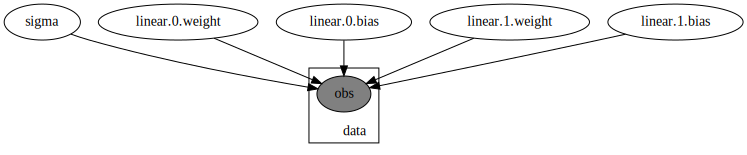

In [7]:
data_x = torch.ones(1,8)
data_y = torch.ones(1,1)
pyro.render_model(model, model_args=(data_x,data_y,))

## Training BNN

Back-by-propagation follows the steps in this figure:

  <img src="figures/Fig2.png" alt="BNN Training" width="600"/>   

In [8]:
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=Trace_ELBO())    

training_dataloader = DataLoader(TrainingData, batch_size=1, shuffle=True)
pbar  = tqdm(training_dataloader)


for j in range(20):
    # calculate the loss and take a gradient step
    
    for i, (x_data, y_data) in enumerate(pbar):

        loss = svi.step(x_data, y_data)

        if i % 10 == 0:
            print("[iteration %04d] loss: %.4f" % (i + 1, loss / (i + 1)))


 31%|███       | 59/192 [00:00<00:00, 198.75it/s]

[iteration 0001] loss: 289.7368
[iteration 0011] loss: 26.6240
[iteration 0021] loss: 13.0009
[iteration 0031] loss: 8.4705
[iteration 0041] loss: 5.8348
[iteration 0051] loss: 4.0292
[iteration 0061] loss: 3.5018
[iteration 0071] loss: 2.5705
[iteration 0081] loss: 2.3233
[iteration 0091] loss: 2.0039
[iteration 0101] loss: 1.5912
[iteration 0111] loss: 1.4251


100%|██████████| 192/192 [00:00<00:00, 317.89it/s]


[iteration 0121] loss: 0.9234
[iteration 0131] loss: 0.9232
[iteration 0141] loss: 0.7476
[iteration 0151] loss: 0.6177
[iteration 0161] loss: 0.6019
[iteration 0171] loss: 0.4173
[iteration 0181] loss: 0.3891
[iteration 0191] loss: 0.2514
[iteration 0001] loss: 68.0827
[iteration 0011] loss: 4.0375
[iteration 0021] loss: 2.5404
[iteration 0031] loss: 1.3953
[iteration 0041] loss: 0.6810
[iteration 0051] loss: 0.5580
[iteration 0061] loss: 0.2409
[iteration 0071] loss: 0.2968
[iteration 0081] loss: 0.1653
[iteration 0091] loss: 0.1797
[iteration 0101] loss: 0.1159
[iteration 0111] loss: 0.0785
[iteration 0121] loss: 0.0698
[iteration 0131] loss: 0.0727
[iteration 0141] loss: 0.0881
[iteration 0151] loss: 0.0334
[iteration 0161] loss: 0.0313
[iteration 0171] loss: 0.0152
[iteration 0181] loss: 0.0380
[iteration 0191] loss: 0.0170
[iteration 0001] loss: 5.6880
[iteration 0011] loss: 0.3059
[iteration 0021] loss: 0.1649
[iteration 0031] loss: 0.1724
[iteration 0041] loss: 0.1376
[iteratio

## Prediction 

In [9]:
from pyro.infer import Predictive 

predictive = Predictive(model, guide=guide, num_samples=100, return_sites=("obs", "_RETURN"))
import pdb
testing_dataloader = DataLoader(TestingData, batch_size=1, shuffle=False)
pbar  = tqdm(testing_dataloader)

samples_list = []
for i, (x_data, y_data) in enumerate(pbar):
    samples = predictive(x_data)
    av_output = samples["_RETURN"].mean()  
    samples_list.append({"Predict":av_output.item(), "GT":y_data.item()})
    
output_samples = pd.DataFrame(samples_list)
y_pred = output_samples["Predict"].values 
y_gt   = output_samples["GT"].values
 

y_pred = TestingData.YScaler.inverse_transform(y_pred.reshape(-1,1)) 
y_gt = TestingData.YScaler.inverse_transform(y_gt.reshape(-1,1)) 

from sklearn import metrics 
print("================== WLS =========================") 
print("MAE:",metrics.mean_absolute_error(y_pred,y_gt))
print("MSE:",metrics.mean_squared_error(y_pred,y_gt))  
print("R2score:",metrics.r2_score(y_pred,y_gt))  


100%|██████████| 61/61 [00:02<00:00, 28.92it/s]

================== WLS =========================
MAE: 4.339778166869364
MSE: 29.52438914658042
R2score: -647.956321190662
